### Marine Acoustics Workbook

In [1]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pywt

# Figures appear in notebook inline
%matplotlib inline


### Read .wav audio

In [2]:
# File path to .wav file
audio_file_path = "../data/humpback.wav"
filename = audio_file_path.split('/')[-1]

# Read entire mono .wav file using default sampling rate
y, sr = librosa.load(audio_file_path, sr=None, mono=True, offset=0.0, duration=None)
print(f'Loaded file: {filename}\n--------------------------------\n\
Duration: {y.size/sr} seconds\n--------------------------------\n\
Sample rate: {sr} Hz\n--------------------------------\n')



Loaded file: humpback.wav
--------------------------------
Duration: 255.65 seconds
--------------------------------
Sample rate: 4000 Hz
--------------------------------



### Define constants (frame_length, hop_length)

In [3]:
# CONSTANTS
frame_length = 100    # window size in samples
hop_length = frame_length//2    # stride length between windows in samples
n_mels = 64    # no. of mel-bands used to partition linear frequencies
n_mfcc = 12    # no. of mfccs to calculate
wavelet = 'morl'    # wavelet type: morlet
scales = np.arange(1, 64) # scales for wavelet
delta_width = 5    # no. of frames over which the delta is calculated

print(f'Frame duration: {1000*frame_length/sr} ms\nOverlap: {100*hop_length/frame_length}%')


Frame duration: 25.0 ms
Overlap: 50.0%


### Functions

In [4]:
def slice_data(data, frame_length, hop_length):
    """Slice 1D array into frames with a given overlap"""
    frame_view = librosa.util.frame(data, frame_length=frame_length, hop_length=hop_length, axis=0)
    
    return frame_view


def apply_cwt(y, sr, scales, wavelet):
    dt = 1/sr # sampling period
    
    # Compute continuous wavelet transform
    wavelet_coeffs, wavelet_freqs = pywt.cwt(y, scales, wavelet=wavelet, sampling_period=dt)
    
    # Display a portion of the scalogram.
    plt.imshow(wavelet_coeffs[:,:400], cmap='coolwarm')
    plt.xlabel("Time")
    plt.ylabel("Scales")
    plt.yticks(scales[0::11])
    plt.title("Scalogram")
    plt.show()

    return wavelet_coeffs, wavelet_freqs


def plot_waveform(y, sr, axis='s', offset=0.0, title='Audio Waveform', xlabel='Time (s)', ylabel='Amplitude'):
    """Plot the signal waveform in the time domain"""

    # Plot
    plt.figure()
    librosa.display.waveshow(y, sr=sr, max_points=sr//2, axis=axis, offset=offset)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def plot_spectrogram(y, sr, n_fft=frame_length, hop_length=hop_length, title='Linear-frequency Power Spectrogram', xlabel='Time (s)', ylabel='Frequency (Hz)'):
    """Plot the linear-frequency power spectrogram"""

    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window='hann')  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)    # STFT in dB
    
    # Plot
    plt.figure()
    librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='s', y_axis='linear')
    plt.colorbar(format="%+2.f dB")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def plot_mel_spectrogram(y, sr, n_fft=frame_length, hop_length=hop_length, n_mels=n_mels, title='Mel-frequency Power Spectrogram', xlabel='Time (s)', ylabel='Frequency (Hz)'):
    """Plot the mel-frequency power spectrogram"""

    D = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=frame_length, hop_length=hop_length, n_mels=n_mels)  # mel-power spectrogram of y
    S_db = librosa.power_to_db(D, ref=np.max)    # mel-power spectrogram in dB
    
    # Plot
    plt.figure()
    librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='s', y_axis='linear')
    plt.colorbar(format="%+2.f dB")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)



### Slice signal into frames

In [5]:
# Create view of sliced signal
y_frames = slice_data(y, frame_length, hop_length)
print(f'Sliced signal into {y_frames.shape[0]} frames with {100*hop_length/frame_length}% overlap and duration {1000*frame_length/sr} ms.')


Sliced signal into 20451 frames with 50.0% overlap and duration 25.0 ms.


### Plot the audio waveform

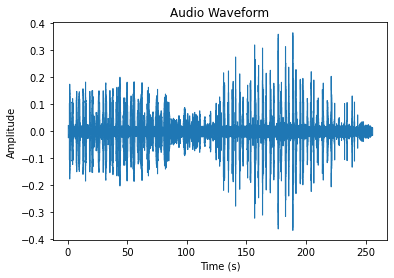

In [6]:
plot_waveform(y, sr)


### Plot a linear-frequency power spectrogram

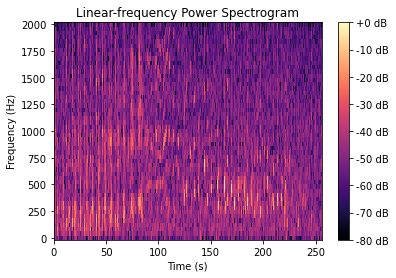

In [7]:
plot_spectrogram(y, sr)


### Plot a mel-frequency power spectrogram

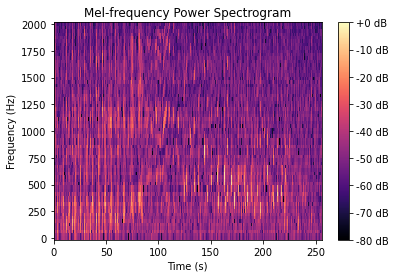

In [8]:
plot_mel_spectrogram(y, sr)


### Calculate MFCCs, Deltas, and Delta-Deltas

In [9]:
# Calculate MFCCs
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=frame_length, hop_length=hop_length, n_mels=n_mels)
print(f'First {n_mfcc} MFCCs:\n------------------------------------------------------------------\n{mfccs[:,0]}')


# Calculate the delta of the mfccs
mfccs_delta = librosa.feature.delta(mfccs, width=delta_width, order=1, axis=-1)


# Calculate the delta-deltas of the mfccs
mfccs_delta_delta = librosa.feature.delta(mfccs, width=delta_width, order=2, axis=-1)



First 12 MFCCs:
------------------------------------------------------------------
[-409.7646       8.581801    15.900955    23.931812     1.0240664
    8.487936    -9.2066555   -5.6914115    7.048259    -0.8699417
    2.377391   -11.291279 ]


### Apply continous wavelet transform

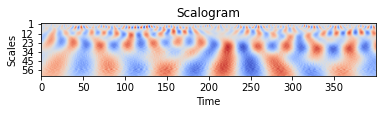


Frequencies associated with the scales:

 [3250.         1625.         1083.33333333  812.5         650.
  541.66666667  464.28571429  406.25        361.11111111  325.
  295.45454545  270.83333333  250.          232.14285714  216.66666667
  203.125       191.17647059  180.55555556  171.05263158  162.5
  154.76190476  147.72727273  141.30434783  135.41666667  130.
  125.          120.37037037  116.07142857  112.06896552  108.33333333
  104.83870968  101.5625       98.48484848   95.58823529   92.85714286
   90.27777778   87.83783784   85.52631579   83.33333333   81.25
   79.26829268   77.38095238   75.58139535   73.86363636   72.22222222
   70.65217391   69.14893617   67.70833333   66.32653061   65.
   63.7254902    62.5          61.32075472   60.18518519   59.09090909
   58.03571429   57.01754386   56.03448276   55.08474576   54.16666667
   53.27868852   52.41935484   51.58730159]


In [10]:
wavelet_coeffs, wavelet_freqs = apply_cwt(y, sr, scales, wavelet)

print("\nFrequencies associated with the scales:\n\n", wavelet_freqs)

